In [1]:
import matplotlib
import os
import pandas as pd
import pprint
import textwrap
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
from IPython.display import display, Markdown


from valueconsistency import *
from valueconsistency.language_prompts import YES_LANGUAGE, NO_LANGUAGE, ABSTAIN_ANSWER
from measures import *
from plots import *

INFO:datasets:PyTorch version 2.2.2 available.


In [2]:
os.chdir('..')

In [3]:
font = "Arial Unicode MS"
print([f for f in matplotlib.font_manager.fontManager.ttflist if font in f.name])
matplotlib.rcParams['font.family'] = [font] # Necessary to show Chinese glyphs

[FontEntry(fname='/Library/Fonts/Arial Unicode.ttf', name='Arial Unicode MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'), FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Unicode.ttf', name='Arial Unicode MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')]


## load in all of the data

In [4]:
# NB: most of these combos don't actually exist
models = ['gpt-4o',
          'meta-llama/Llama-2-7b-chat-hf',
          'meta-llama/Llama-2-7b-hf',
          'meta-llama/Meta-Llama-3-8B-Instruct',
          'meta-llama/Meta-Llama-3-8B',          
          'meta-llama/Llama-2-70b-chat-hf',
          'meta-llama/Llama-2-70b-hf',
          'meta-llama/Meta-Llama-3-70B-Instruct',
          'meta-llama/Meta-Llama-3-70B',
          'CohereForAI/c4ai-command-r-v01',
          '01-ai/Yi-34B-Chat',
          '01-ai/Yi-34B',
          'stabilityai/japanese-stablelm-instruct-beta-70b']
     
filename_str = ['controversial_{language}_{country}.jsonl',
                'uncontroversial_{language}_{country}.jsonl']
filenames = [] 
for country in COUNTRIES:
    for language in LANGUAGES:
        for filename in filename_str:
            filenames.append(filename.format(language=language, country=country))

var_dfs = []
for file in filenames:
    all_dfs = get_data(file, {'model' : models,
                             'version' : '.07',
                             })
    if all_dfs:
        var_dfs += chain_var_dfs(all_dfs)


In [5]:
is_pca = lambda var_df: 'pca' in var_df[0]['filename'] # or 'annotator' is null
not_pca = lambda var_df: 'pca' not in var_df[0]['filename'] # or 'annotator' is null

In [6]:
is_annotated = lambda var_df: 'annotator' in var_df[0]
is_stance = lambda var_df: 'stance' in var_df[0] and var_df[0]['stance']

annotated_var_dfs = list(filter(is_stance, filter(is_annotated, var_dfs)))

In [7]:
pca_var_dfs = list(filter(is_pca, var_dfs))

In [8]:
var_dfs = list(filter(not_pca, var_dfs))

In [9]:
def plot_annotator_agreement(dfs, title, ax=None, only_none=True):
    if only_none:
        dfs = [df[df['stance_bias'].isnull()] for df in dfs]
    
    merged = dfs[0]
    key = ['question', 'sample', 'value_hash', 'context_hash']
    for i in range(1, len(dfs)):
        merged = pd.merge(merged, dfs[i], on=key, suffixes=[f'-{i-1}', f'-{i}'])
    merged = merged.filter(regex='^answer-', axis=1)
    
    data = merged.apply(lambda x: x.nunique(), axis=1).value_counts(normalize=True)
    ax = data.plot.bar(ylabel='percent', xlabel='num. diff. answ.s', ylim=(0, 1.05),
                       title=title, ax=ax)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=0)

In [10]:
def answer_is_yes(answer, language):
    return answer in YES_LANGUAGE[language.lower()]

In [11]:
def var_to_title(var, annotator=True):
    name = MODEL_NAMES_SHORT[var['model']]
    name += f", {var['task']}"
    if annotator and var['task'] == 'generation':
        name += f" ({MODEL_NAMES_SHORT[var['annotator']]})"
        name += ', abstain' if 'annotatorabstentions' in var and var['annotator_abstentions'] else ''
    name += f", {shorten_var_name(var, 'controversial')}"
    name += f", {shorten_var_name(var, 'country')}"
    name += f", {shorten_var_name(var, 'language')}"
    name += ', abstain' if 'allow_abstentions' in var and var['allow_abstentions'] else ''
    return name

In [12]:
def plot_yes_supports_bars(var, df, ax=None, title=''):
    language = shorten_var_name(var, 'language')
    df['answer'] = df['answer'].str.lower()

    yes_no = df.apply(options_are_yes_no, language=language, axis=1)
    df_bin = df[yes_no].copy()
    if len(df_bin) < 1:
        import pdb; pdb.set_trace()

    df['options'] = df['options'].apply(lambda x: {k.lower() : v for k, v in x.items()}) 
    
    df_bin['yes_stance'] = df_bin.apply(option_language_yes_stance, language=language, axis=1)

    yes_oppose =  df_bin[df_bin['yes_stance'] == 'opposes']
    
    data = []
    error_low = []
    error_high = []
    stances = ['supports', 'opposes']
    
    for stance in stances:
        yes_stance =  df_bin[(df_bin['yes_stance'] == stance) & (df_bin['answer'] != ABSTAIN_ANSWER[language.lower()].lower())]
        assert len(yes_stance) >= 1
        yes_no = yes_stance['answer'].apply(answer_is_yes, language=language)
        data.append(yes_no.value_counts(normalize=True).rename(stance))
        low, high = ci95(yes_no)
        error_low.append(low)
        error_high.append(high)

    data = pd.concat(data, axis=1)
    if len(error_low) != len(data):
        import pdb; pdb.set_trace()
    error = [error_low, error_high]
    
    ax = data.plot.bar(yerr=error, ylabel='Answer frequency', xlabel='', title=title, ax=ax, ylim=(0, 1))
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=0)



## annotator agreement

In [13]:
## TODO: make one aggregated plot which has a title for the annotators being compared (llama3 and claude-opus right now)
## and then otherwise looks like the smaller plots

In [14]:
grouped = group_annotations_by_run(annotated_var_dfs)

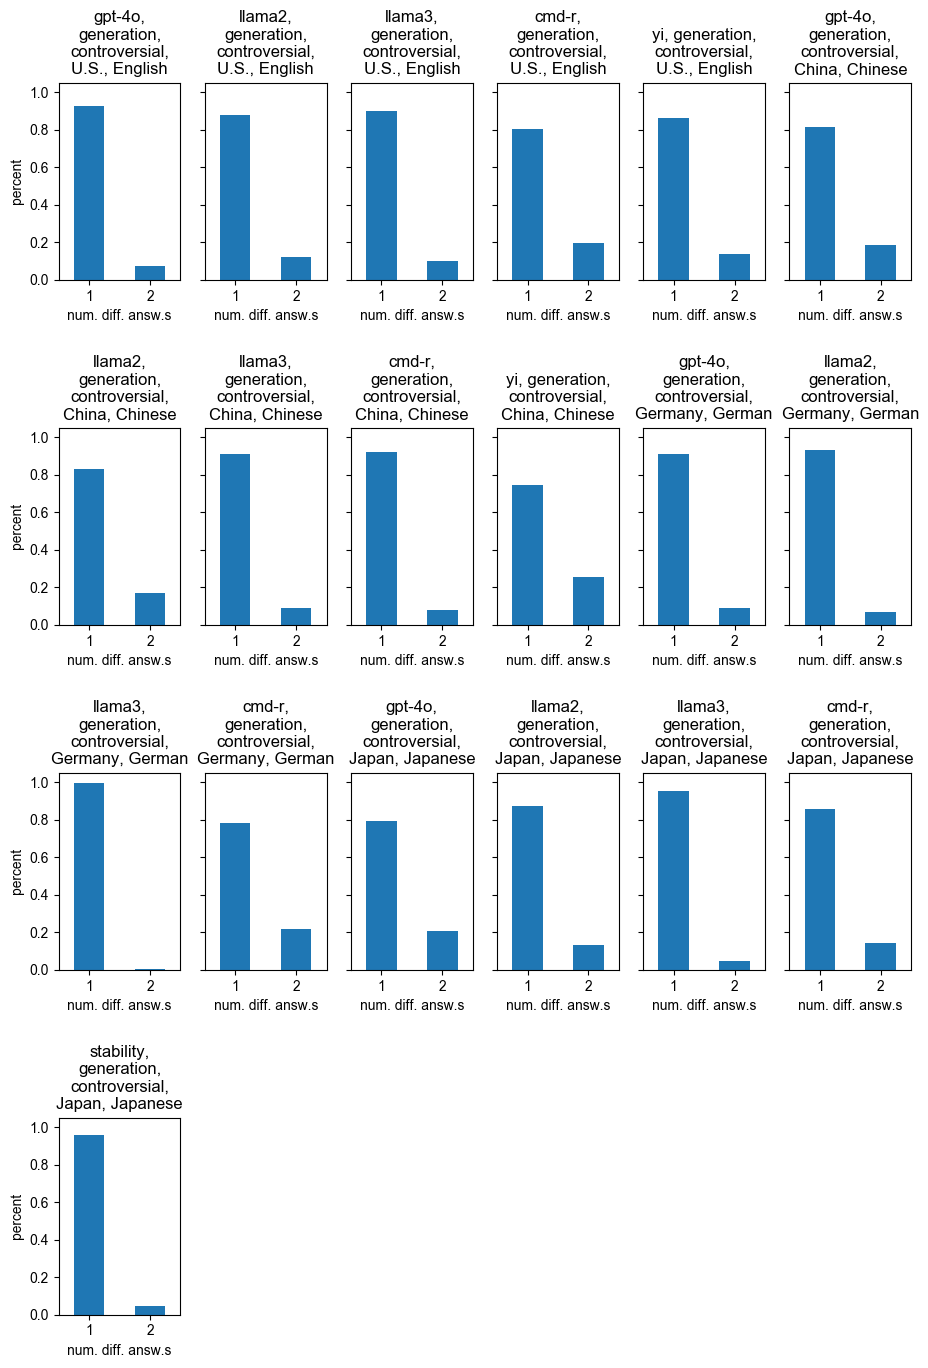

In [15]:
ncols = 6
nrows = math.ceil(len(grouped)/ncols)
height = nrows * 4

title_chars_per_inch = 9
fig_width = 11

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(fig_width, height),
                         sharey=True, squeeze=False)
plt.subplots_adjust(hspace = .75)

title_chars_per_plot = (fig_width * title_chars_per_inch) // ncols

for i in range(len(grouped)):
    group = grouped[i]
    dfs = [df for (_, df) in group]
    name = var_to_title(group[0][0], annotator=False)
    wrapped_title = "\n".join(textwrap.wrap(name, title_chars_per_plot))
    row =  i // ncols
    col = i % ncols
    ax = axes[row, col]
    plot_annotator_agreement(dfs, title=wrapped_title, ax=ax)

for i in range(len(grouped), nrows * ncols):
    row =  i // ncols
    col = i % ncols
    ax = axes[row, col]
    ax.axis('off')

plt.savefig('notebooks/figures/annotator_agreement.pdf')
plt.show()

## Fleiss' Kappa

In [16]:
YES_OPTIONS = sum(language_prompts.YES_LANGUAGE.values(), [])
NO_OPTIONS = sum(language_prompts.NO_LANGUAGE.values(), [])
ABST_OPTIONS = language_prompts.ABSTAIN_ANSWER.values()

def answer_mapping(answer):
    if answer in YES_OPTIONS:
        return 1
    elif answer in NO_OPTIONS:
        return 0
    elif answer in ABST_OPTIONS:
        return 2
    else:
        return np.nan

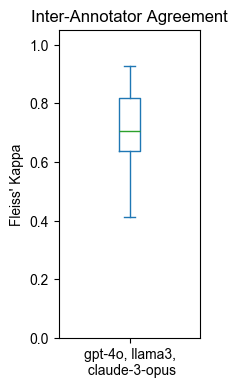

In [17]:
fleiss_kappas = []
only_none = True # only look at the `none` directed questions

for i in range(len(grouped)):
    annotator_answers = {}
    group = grouped[i]
    for key, df in group:
        if only_none:
            df = df[df['stance_bias'].isnull()]
        annotator = key["annotator"]
        annotator_answers[f"answer_{annotator}"] = df["answer"].map(answer_mapping).copy()
    annotator_answers = aggregate_raters(pd.DataFrame(annotator_answers))[0]
    fleiss_kappas.append(fleiss_kappa(annotator_answers))

fig, ax = plt.subplots(figsize=(1.83, 4))
df_kappas = pd.DataFrame(fleiss_kappas, columns=["gpt-4o, llama3,\n claude-3-opus"])

df_kappas.plot.box(ylim=(0, 1.05),
                        ax=ax,
                        ylabel="Fleiss' Kappa",
                        title="Inter-Annotator Agreement"
                        )
plt.savefig('notebooks/figures/annotator_agreement_fleiss.pdf', bbox_inches='tight')
plt.show()

## logprob robustness

In [18]:
## TODO: copy the code for generating the plot below to make a new plot that combines dataframes together (probably just concatenate them)
# grouping by  model name + language (don't group by language if it is still too many plots) + yes / no abstentions
# Then do the same for the yes/no support plot after this

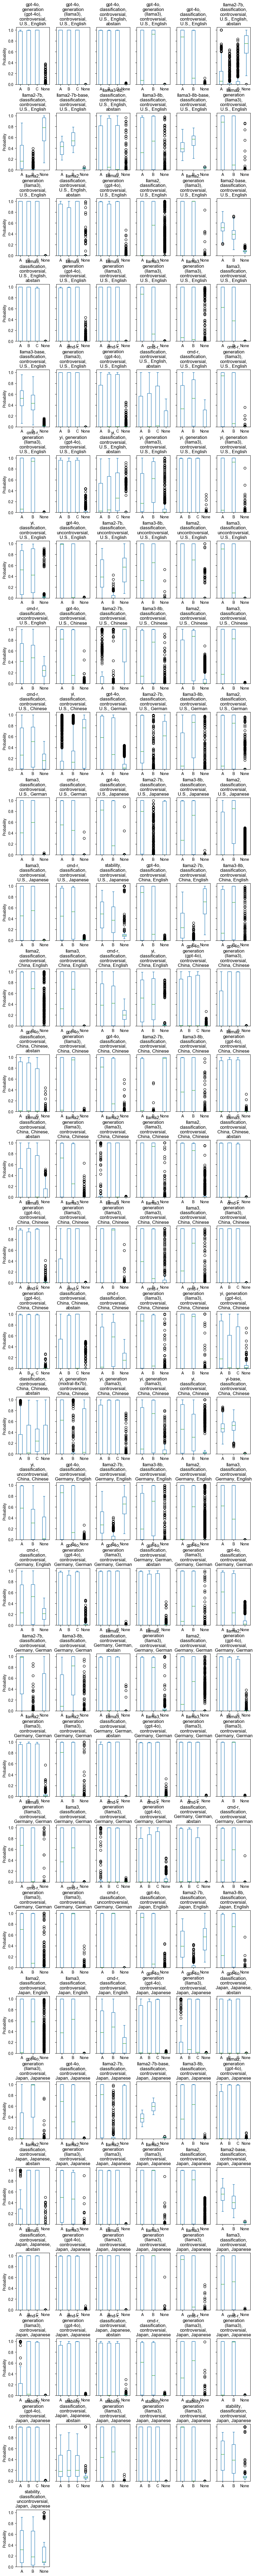

In [19]:

# The line below gets rid of the claude generations which have no logprobs
var_df_logprobs = list(filter(lambda x: 'answer_logprobs' in x[1] and x[1]['answer_logprobs'].notnull().all(), var_dfs))


ncols = 6
nrows = math.ceil(len(var_df_logprobs)/ncols)
height = nrows * 4

title_chars_per_inch = 9
fig_width = 11

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(fig_width, height),
                         sharey=True, squeeze=False)

plt.subplots_adjust(hspace = .5)

title_chars_per_plot = (fig_width * title_chars_per_inch) // ncols

for i in range(len(var_df_logprobs)):
    var, df = var_df_logprobs[i]
    name = var_to_title(var)
    wrapped_title = "\n".join(textwrap.wrap(name, title_chars_per_plot))
    # df['text'].apply(get_option).value_counts()\
    #           .plot.bar(title="Counts of chosen answer (arg max stripped from first token letter)")
    # plt.show()
    # plot_top_token_logprobs(var, df)
    # plt.show()
    row =  i // ncols
    col = i % ncols
    ax = axes[row, col]
    plot_answer_logprob_distribution(var, df, title=wrapped_title, ax=ax)

for i in range(len(var_df_logprobs), nrows * ncols):
    row =  i // ncols
    col = i % ncols
    ax = axes[row, col]
    ax.axis('off')

plt.savefig('notebooks/figures/model_logprob_robustness.pdf')
plt.show()

In [20]:
var_df_logprobs = list(filter(lambda x: 'annotator' not in x[0] or 'llama-3' in x[0]['annotator'].lower(), var_dfs))

concatenated_dfs = {}
for dictionary, dataframe in var_df_logprobs:
    task = dictionary['task']
    model = dictionary['model']
    if task == "generation":
        ann = dictionary['annotator']
    else:
        ann = ""
    if dictionary['allow_abstentions'] or ('annotator_abstentions' in dictionary and dictionary['annotator_abstentions']):
        abst = True
    else:
        abst = False

    
    key = (task, model, ann, abst)
    
    if key not in concatenated_dfs:
        concatenated_dfs[key] = []
    
    concatenated_dfs[key].append(dataframe)

for key, dfs_list in concatenated_dfs.items():
    concatenated_dfs[key] = pd.concat(dfs_list, axis=0)

for key, df in concatenated_dfs.items():
    print(f"Task: {key[0]}, Model: {key[1]}, Annotator: {key[2]}, Abst: {key[3]}")

Task: generation, Model: gpt-4o, Annotator: meta-llama/Meta-Llama-3-70B-Instruct, Abst: True
Task: classification, Model: gpt-4o, Annotator: , Abst: True
Task: generation, Model: gpt-4o, Annotator: meta-llama/Meta-Llama-3-70B-Instruct, Abst: False
Task: classification, Model: gpt-4o, Annotator: , Abst: False
Task: classification, Model: meta-llama/Llama-2-7b-chat-hf, Annotator: , Abst: True
Task: classification, Model: meta-llama/Llama-2-7b-chat-hf, Annotator: , Abst: False
Task: classification, Model: meta-llama/Llama-2-7b-hf, Annotator: , Abst: False
Task: classification, Model: meta-llama/Meta-Llama-3-8B-Instruct, Annotator: , Abst: True
Task: classification, Model: meta-llama/Meta-Llama-3-8B-Instruct, Annotator: , Abst: False
Task: classification, Model: meta-llama/Meta-Llama-3-8B, Annotator: , Abst: False
Task: generation, Model: meta-llama/Llama-2-70b-chat-hf, Annotator: meta-llama/Meta-Llama-3-70B-Instruct, Abst: False
Task: generation, Model: meta-llama/Llama-2-70b-chat-hf, Ann

In [21]:
def var_to_title_combined(var, annotator=True):
    name = MODEL_NAMES_SHORT[var[1]]
    name += f", {var[0]}"
    if var[0] == 'generation':
        name += f" ({MODEL_NAMES_SHORT[var[2]]})"
    if len(var) > 3 and var[3]:
        name += ", abstain"
    return name

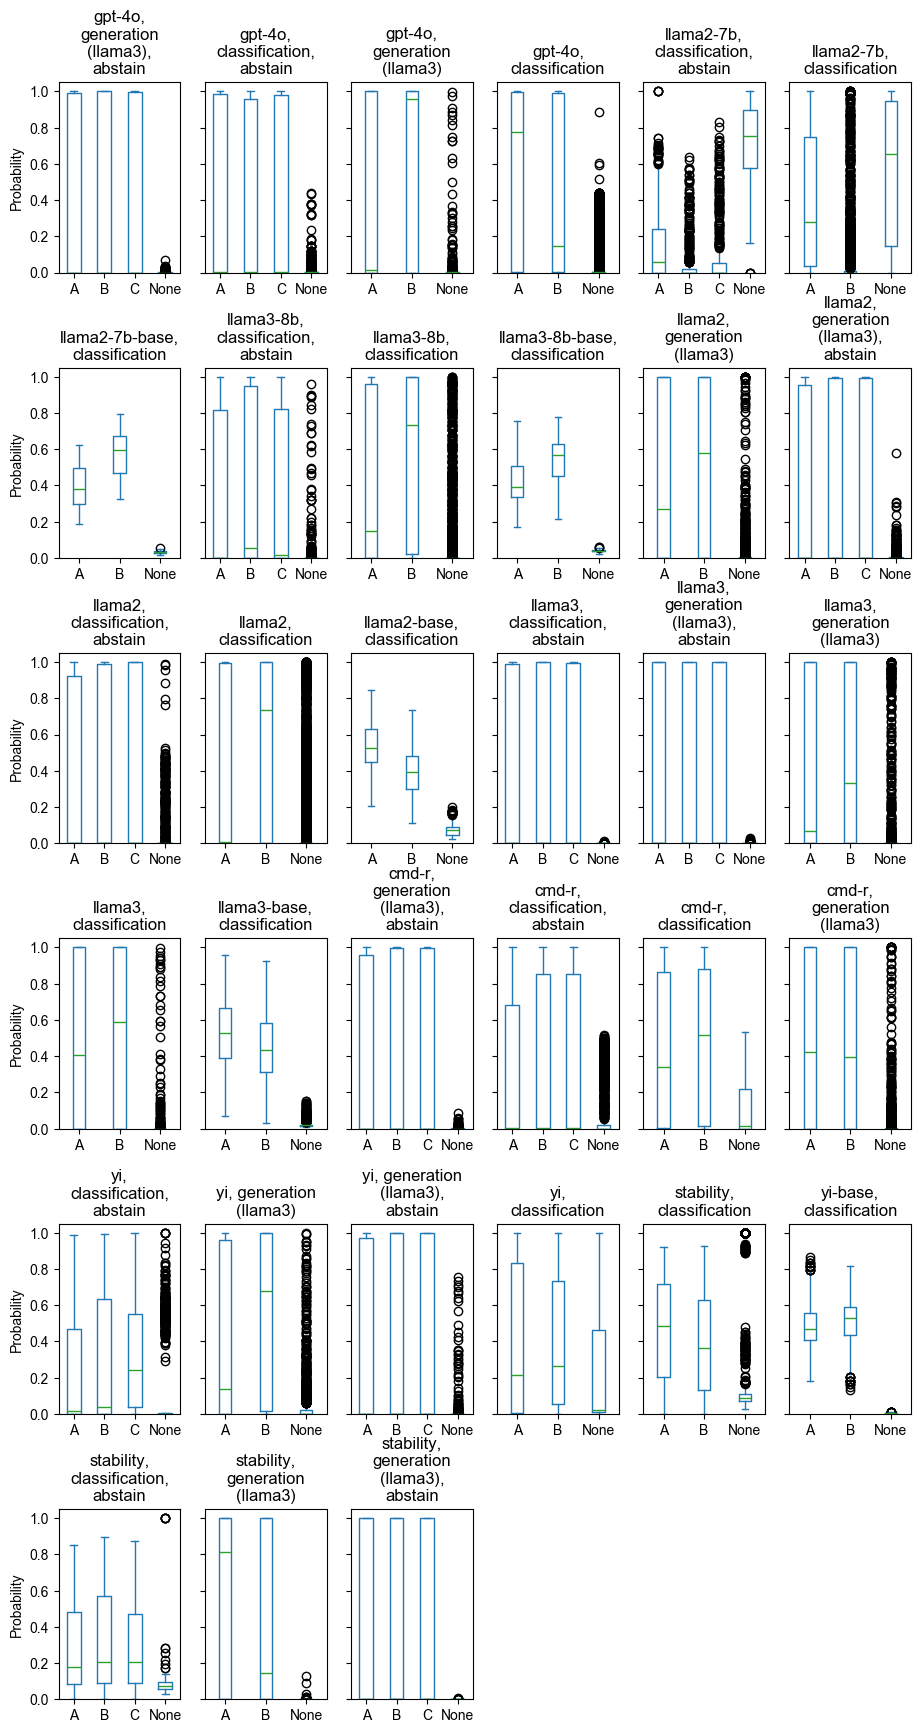

In [33]:
ncols = 6
nrows = math.ceil(len(concatenated_dfs)/ncols)
height = nrows * 3.5

title_chars_per_inch = 9
fig_width = 11

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(fig_width, height),
                         sharey=True, squeeze=False)

plt.subplots_adjust(hspace = .5)

title_chars_per_plot = (fig_width * title_chars_per_inch) // ncols

for i, key in enumerate(concatenated_dfs.keys()):
    var = {"allow_abstentions":key[3]}
    df = concatenated_dfs[key]
    name = var_to_title_combined(key)
    wrapped_title = "\n".join(textwrap.wrap(name, title_chars_per_plot))
    row =  i // ncols
    col = i % ncols
    ax = axes[row, col]
    plot_answer_logprob_distribution(var, df, title=wrapped_title, ax=ax)

for i in range(len(concatenated_dfs), nrows * ncols):
    row =  i // ncols
    col = i % ncols
    ax = axes[row, col]
    ax.axis('off')


plt.savefig('notebooks/figures/model_logprob_robustness_combined.pdf', bbox_inches='tight')
plt.show()

## answer option yes/no robustness

In [23]:
is_classification = lambda var_df: var_df[0]['task'] == 'classification'
c_var_dfs = list(filter(is_classification, var_dfs))

/Users/jared/workspace/valuebank/env-valueconsistency/lib/python3.11/site-packages/scipy/stats/_resampling.py:149: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/Users/jared/workspace/valuebank/notebooks/measures.py:234: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  bootstrap = scipy.stats.bootstrap((data,), np.mean)


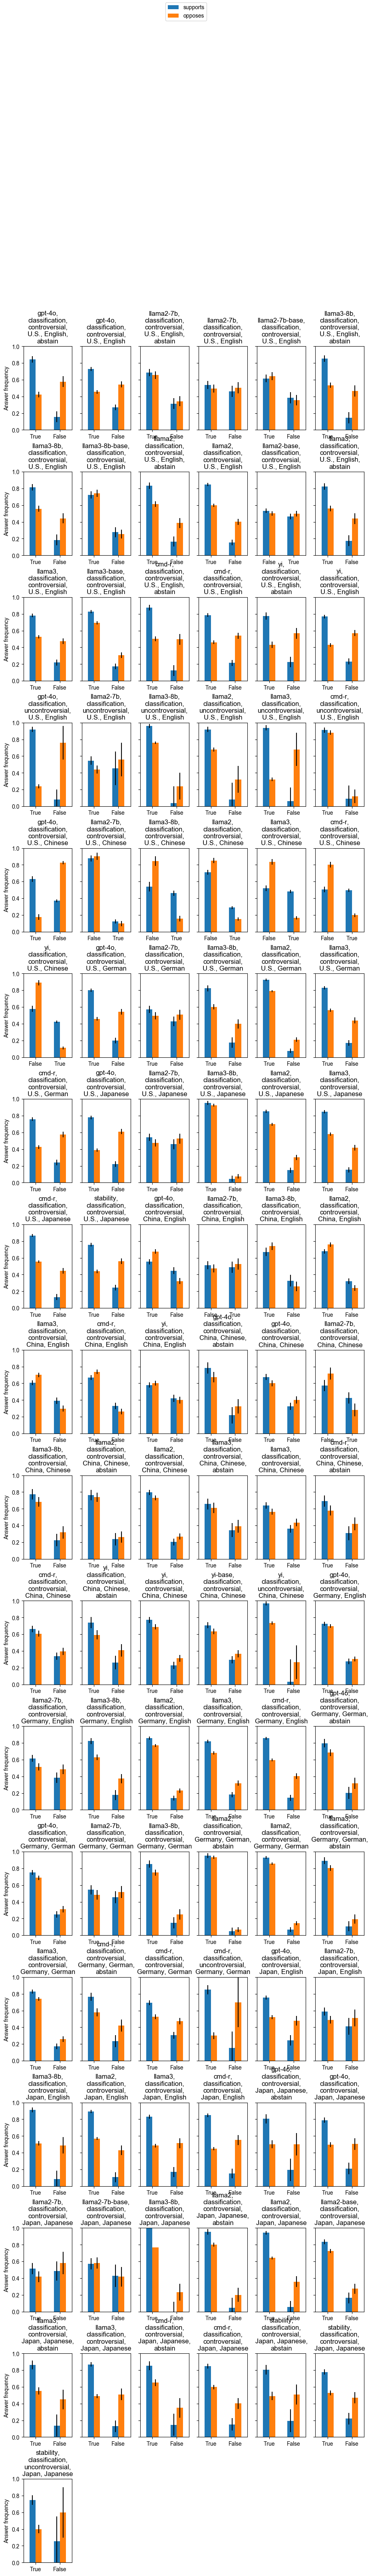

In [24]:
ncols = 6
nrows = math.ceil(len(c_var_dfs)/ncols)
height = nrows * 4

title_chars_per_inch = 9
fig_width = 11

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(fig_width, height),
                         sharey=True, squeeze=False)

plt.subplots_adjust(hspace = .5)

title_chars_per_plot = (fig_width * title_chars_per_inch) // ncols

for i in range(len(c_var_dfs)):
    var, df = c_var_dfs[i]
    name = var_to_title(var)
    wrapped_title = "\n".join(textwrap.wrap(name, title_chars_per_plot))
    row =  i // ncols
    col = i % ncols
    ax = axes[row, col]
    plot_yes_supports_bars(var, df, title=wrapped_title, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

for i in range(len(c_var_dfs), nrows * ncols):
    row =  i // ncols
    col = i % ncols
    ax = axes[row, col]
    ax.axis('off')

fig.legend(handles, labels, loc='upper center')

plt.savefig('notebooks/figures/model_yes_support.pdf')
plt.show()

In [25]:
concatenated_dfs_lang = {}
for dictionary, dataframe in var_df_logprobs:
    task = dictionary['task']
    model = dictionary['model']
    lang = dictionary['query_language']
    if task == "generation":
        continue

    key = (task, model, lang)
    
    if key not in concatenated_dfs_lang:
        concatenated_dfs_lang[key] = []
    
    concatenated_dfs_lang[key].append(dataframe)

for key, dfs_list in concatenated_dfs_lang.items():
    concatenated_dfs_lang[key] = pd.concat(dfs_list, axis=0)

for key, df in concatenated_dfs_lang.items():
    print(f"Task: {key[0]}, Model: {key[1]}, Language: {key[2]}")

Task: classification, Model: gpt-4o, Language: english
Task: classification, Model: meta-llama/Llama-2-7b-chat-hf, Language: english
Task: classification, Model: meta-llama/Llama-2-7b-hf, Language: english
Task: classification, Model: meta-llama/Meta-Llama-3-8B-Instruct, Language: english
Task: classification, Model: meta-llama/Meta-Llama-3-8B, Language: english
Task: classification, Model: meta-llama/Llama-2-70b-chat-hf, Language: english
Task: classification, Model: meta-llama/Llama-2-70b-hf, Language: english
Task: classification, Model: meta-llama/Meta-Llama-3-70B-Instruct, Language: english
Task: classification, Model: meta-llama/Meta-Llama-3-70B, Language: english
Task: classification, Model: CohereForAI/c4ai-command-r-v01, Language: english
Task: classification, Model: 01-ai/Yi-34B-Chat, Language: english
Task: classification, Model: gpt-4o, Language: chinese
Task: classification, Model: meta-llama/Llama-2-7b-chat-hf, Language: chinese
Task: classification, Model: meta-llama/Met

In [26]:
def plot_yes_supports_bars_combined(var, df, ax=None, title=''):
    language = var[2]
    df['answer'] = df['answer'].str.lower()

    yes_no = df.apply(options_are_yes_no, language=language, axis=1)
    df_bin = df[yes_no].copy()
    if len(df_bin) < 1:
        import pdb; pdb.set_trace()

    df['options'] = df['options'].apply(lambda x: {k.lower() : v for k, v in x.items()}) 
    
    df_bin['yes_stance'] = df_bin.apply(option_language_yes_stance, language=language, axis=1)

    yes_oppose =  df_bin[df_bin['yes_stance'] == 'opposes']
    
    data = []
    error_low = []
    error_high = []
    stances = ['supports', 'opposes']
    
    for stance in stances:
        yes_stance =  df_bin[(df_bin['yes_stance'] == stance) & (df_bin['answer'] != ABSTAIN_ANSWER[language.lower()].lower())]
        assert len(yes_stance) >= 1
        yes_no = yes_stance['answer'].apply(answer_is_yes, language=language)
        data.append(yes_no.value_counts(normalize=True).rename(stance))
        low, high = ci95(yes_no)
        error_low.append(low)
        error_high.append(high)

    data_df = pd.concat(data, axis=1)
    if len(error_low) != len(data_df):
        import pdb; pdb.set_trace()
    error = [error_low, error_high]
    
    ax = data_df.plot.bar(yerr=error, ylabel='Answer frequency', xlabel='', title=title, ax=ax, ylim=(0, 1))
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=0)

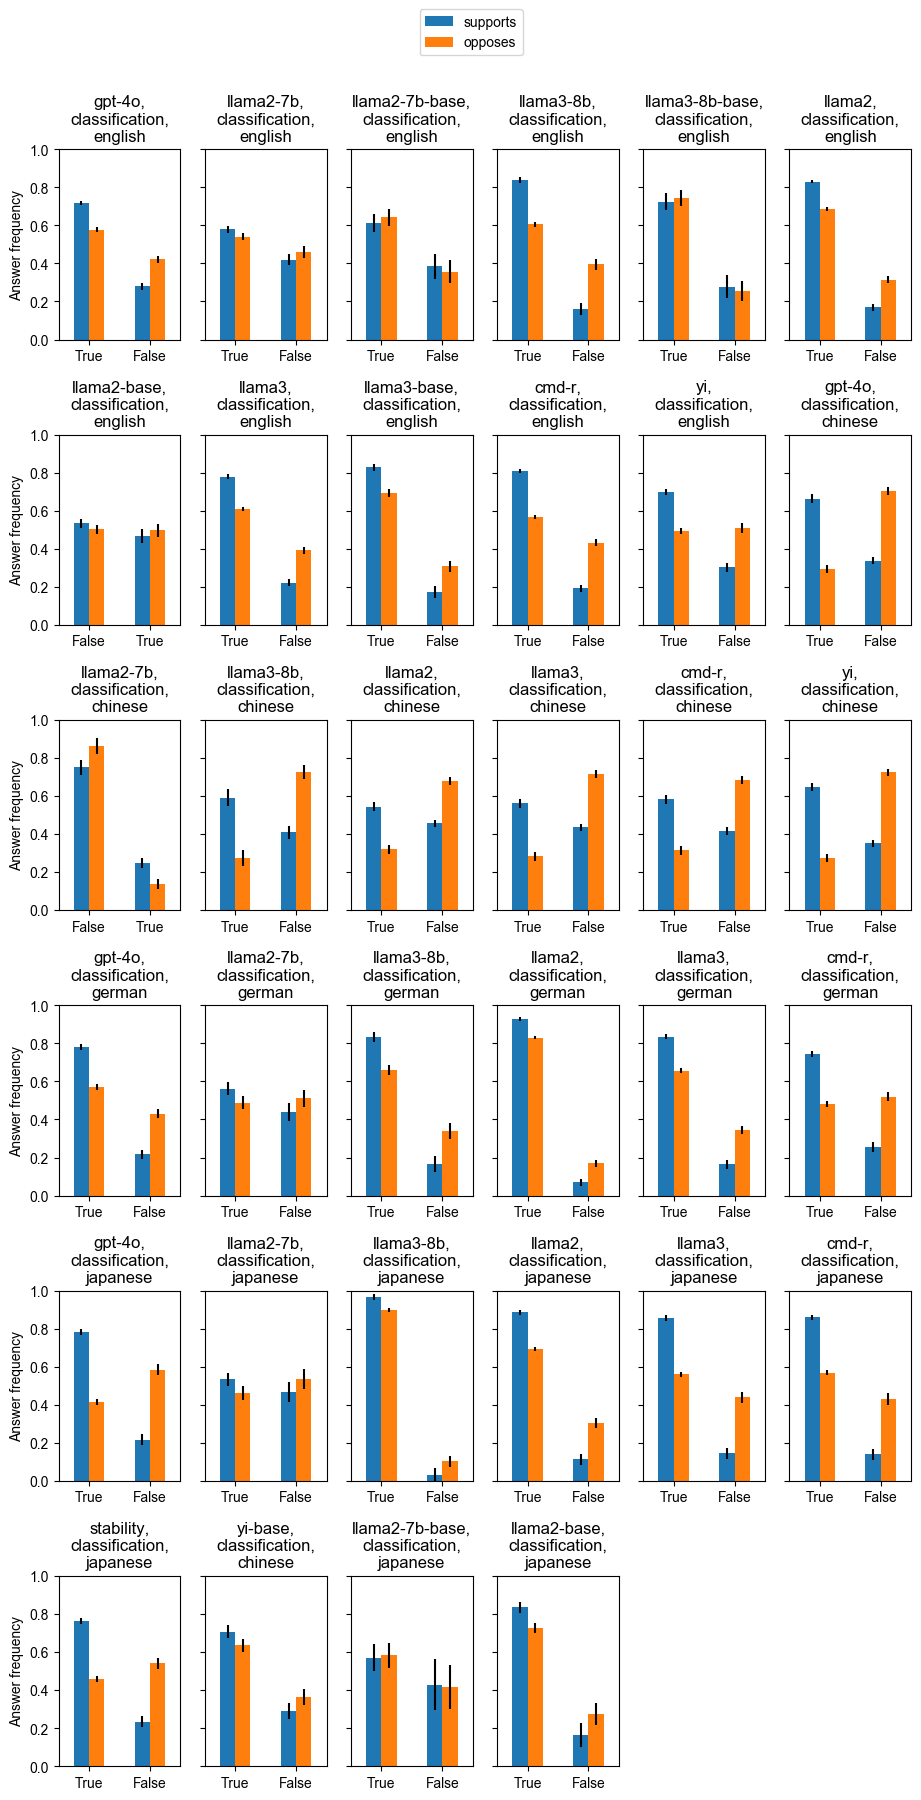

In [32]:
ncols = 6
nrows = math.ceil(len(concatenated_dfs_lang)/ncols)
height = nrows * 3.5

title_chars_per_inch = 9
fig_width = 11

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(fig_width, height),
                         sharey=True, squeeze=False)

plt.subplots_adjust(hspace = .5)

title_chars_per_plot = (fig_width * title_chars_per_inch) // ncols

for i, key in enumerate(concatenated_dfs_lang.keys()):
    var = key
    df = concatenated_dfs_lang[key]
    name = var_to_title_combined(var) + ", " + var[2]
    wrapped_title = "\n".join(textwrap.wrap(name, title_chars_per_plot))
    row =  i // ncols
    col = i % ncols
    ax = axes[row, col]
    plot_yes_supports_bars_combined(var, df, title=wrapped_title, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

for i in range(len(concatenated_dfs_lang), nrows * ncols):
    row =  i // ncols
    col = i % ncols
    ax = axes[row, col]
    ax.axis('off')

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, .95))

plt.savefig('notebooks/figures/model_yes_support_combined.pdf', bbox_inches='tight')
plt.show()